In [1]:
import os, sys
import torch
import pickle
import numpy as np
from scipy.misc import imsave, imshow
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from torch.autograd import Variable
import math
import torch
import seaborn as sns
from matplotlib import offsetbox

In [2]:
import os
import sys
import inspect
_parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe())))))
sys.path.insert(0, _parent_dir)

In [3]:
import pandas as pd
from dqn.utils.io import read_json, read_pickle
from dqn.utils.plot import plot_state
from dqn.utils.math import boltzmann
from dqn.teacher.snapshots_teacher import SnapshotsTeacher
from dqn.teacher.teacher_centers import SnapshotDistillation
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.colors as colors
from IPython.display import Image
from tensorboardX import SummaryWriter
import scipy
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(os.fdopen(1, "w")))
sns.set_style("darkgrid")
%config Application.log_level="DEBUG"
%load_ext autoreload
%autoreload 2

In [4]:
def millions(x, pos):
    return '%1.1fM' % (x*1e-6)
million_formatter = FuncFormatter(millions)
def hundreds(x, pos):
    return int(x)
int_formatter = FuncFormatter(hundreds)

In [5]:
def load_summary_data(exp_path, train=True):
    _summary_flag = "training" if train else "testing"
    summary = pd.read_json(os.path.join(exp_path, "episodes", 
                                        _summary_flag + "_summary.txt"), orient="index")
    summary.index = summary.index.map(int)
    summary.sort_index(inplace=True)
    summary["cum_steps"] = summary["steps"].cumsum()
    return summary

In [6]:
def find_episode_with_highest_rewards(train_summary):
    _episode = train_summary.iloc[train_summary["total_rew"].idxmax()]
    print(_episode)
    return _episode.name

In [7]:
def load_episode(episode_num):
    summary = pd.read_pickle(os.path.join(exp_path, "episodes", 
                                          "episode_train_{0}.pkl".format(episode_num)))
    return summary

In [8]:
def display_episode(episode):
    gif_location = os.path.join(exp_path, "episodes")
    episode.to_animation(gif_location)
    with open(os.path.join(gif_location, "episode_train_{0}.gif".format(episode.episode_num)),'rb') as f:
        display(Image(data=f.read(), format='png'))

In [9]:
def plot_one_history(ax, data, y, title, x="steps", window=100, alpha_fill=0.2):
    _y = data[y]
    assert len(_y) > window
    if x == "steps":
        _x = data["cum_steps"]
    else:
        _x = data.index
    _error = _y.rolling(window=window, min_periods=1, center=False).std()
    _smooth = _y.rolling(window=window, min_periods=1, center=False).mean()
    ymin = _smooth - _error
    ymax = _smooth + _error
    ax.plot(_x, _smooth)
    ax.fill_between(_x, ymax, ymin, alpha=alpha_fill)
    return _x.iloc[-1]

In [10]:
def plot_histories(summaries, y, title, x="steps", window=100, alpha_fill=0.2):
    ax = plt.gca()
    legends = []
    x_limit = []
    for summary, legend in summaries:
        _x_limit = plot_one_history(ax, summary, y, title, x=x, window=window, alpha_fill=alpha_fill)
        x_limit.append(_x_limit)
        legends.append(legend)
    if x == "steps":
        _x = summaries[0][0]["cum_steps"]
        _formater = million_formatter
    else:
        _x = summaries[0][0].index
        _formater = int_formatter
    ax.xaxis.set_major_formatter(_formater)
    ax.set_title(title)
    ax.set_xlim(0, np.mean(x_limit))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.legend(legends, loc='best')
    plt.show()

In [11]:
game_name = "Pong"
teacher_format = "../runs/" + game_name.lower() + "_standard_fast_({0})"
teacher_ids = range(1, 5)

In [12]:
teachers_path = [teacher_format.format(i) for i in teacher_ids]

In [13]:
train_summary = [load_summary_data(path, train=True) for path in teachers_path]

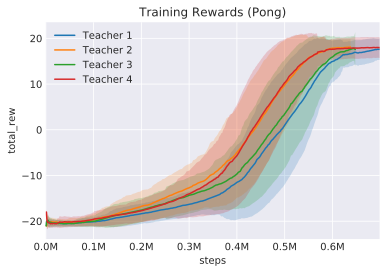

In [14]:
plot_histories(
    [(summary, "Teacher {0}".format(i)) for summary, i in zip(train_summary, teacher_ids)],
    x="steps",
    y="total_rew", 
    title="Training Rewards ({0})".format(game_name))

In [46]:
teacher_format = "../runs/" + game_name.lower() + "_snapshot_fast_({0})_(5)"
teacher_ids = [5]
teachers_path = [teacher_format.format(i) for i in teacher_ids]
train_summary = [load_summary_data(path, train=True) for path in teachers_path]

In [55]:
teacher_path = "../runs/" + game_name.lower() + "_standard_fast_(1)"
teacher_summary = load_summary_data(teacher_path, train=True)

In [56]:
learner_path = "../runs/" + game_name.lower() + "_standard_fast_(5)"
learner_summary = load_summary_data(learner_path, train=True)

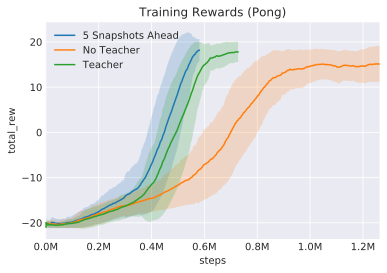

In [58]:
plot_histories(
    [(summary, "{0} Snapshots Ahead".format(i)) for summary, i in zip(train_summary, teacher_ids)] + [(learner_summary, "No Teacher")] + [(teacher_summary, "Teacher")],
    x="steps",
    y="total_rew", 
    title="Training Rewards ({0})".format(game_name))